In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import time

In [2]:
def parse_category_txt(path: str) -> dict:
    import re

    category_map = {}
    current_key = None

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Detekce nového klíče
            if ":" in line:
                # Příklad: "MSZoning: Identifies the zoning..."
                current_key = line.split(":")[0].strip()
                category_map[current_key] = []
            elif current_key:
                # Detekuj platnou hodnotu - první "slovo" na řádku
                parts = re.split(r"\s+", line)
                if parts and len(parts[0]) > 0:
                    # Zajistí, že nepřidáme omylem prázdný řetězec
                    category_map[current_key].append(parts[0])

    return category_map


data_categories = parse_category_txt("data_set\data_description.txt")

In [ ]:
len(data_categories.keys())

In [ ]:
import pandas as pd
import numpy as np

x_all_cat_df = pd.DataFrame(index=df.index)

for col in data_categories.keys():
    if not col in df.columns:
        print(col)

In [ ]:
x_all_cat_map = []

import pandas as pd
import numpy as np

x_all_cat_df = pd.DataFrame(index=df.index)

for col in data_categories.keys():
    if col in df.columns:
        x_all_cat_df[col] = df[col]
    else:
        x_all_cat_df[col] = np.nan  # nebo třeba "NA", nebo 0
    # if index == 0:
    #     break

In [ ]:
data_categories["MSSubClass"]

In [ ]:
list(data_categories.keys())

# Load Data


Load train data


In [3]:
path_train_data = "data_set/train.csv"

df = utils.load_csv_data(path_train_data)

# Print the loaded data
if isinstance(df, pd.DataFrame):
    print(f"dimension train data: {df.shape}")
    print(f"dimension train data: {type(df)}")
else:
    print("train_data is not a DataFrame")

del path_train_data

Successfully loaded data from data_set/train.csv
dimension train data: (1460, 81)
dimension train data: <class 'pandas.core.frame.DataFrame'>


## use One-hot and scaler to prepare train data


In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

try:
    del x_encoded
except:
    print()


def ensure_all_dummies(df: pd.DataFrame, data_categories: dict) -> pd.DataFrame:
    """
    Ensures that all expected dummy columns exist in the DataFrame.
    Adds missing columns with zero values in bulk to avoid fragmentation.
    """
    missing_cols = []
    for col, values in data_categories.items():
        for val in values:
            dummy_col = f"{col}_{val}"
            if dummy_col not in df.columns:
                missing_cols.append(dummy_col)

    if missing_cols:
        missing_df = pd.DataFrame(0, index=df.index, columns=missing_cols)
        df = pd.concat([df, missing_df], axis=1)

    return df


# 0. Extract and scale the target column
scaler_sale_price = StandardScaler()
y = scaler_sale_price.fit_transform(df[["SalePrice"]])  # shape: (n_samples, 1)

x = df.copy()
if "SalePrice" in x.columns:
    x = x.drop("SalePrice", axis=1)
if "Id" in x.columns:
    x = x.drop("Id", axis=1)

# 1. Split columns by data type
numerical_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()

# 2. Handle missing values
x[categorical_cols] = x[categorical_cols].fillna("NA")
x[numerical_cols] = x[numerical_cols].fillna(-1)

for col in data_categories.keys():
    if not col in x.columns:
        print(col)
        break

# 3. One-hot encode categorical features
x_encoded = pd.get_dummies(x, columns=categorical_cols)

# Ensure all dummy columns exist
x_encoded = ensure_all_dummies(x_encoded, data_categories)

# 4. Normalize numerical features
scaler_inputData = StandardScaler()
x_encoded[numerical_cols] = scaler_inputData.fit_transform(x_encoded[numerical_cols])

# 5. Define feature matrix
x = x_encoded

# 6. Split into training and validation sets
x_train_pd, x_val_pd, y_train_pd, y_val_pd = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# 7. Convert to NumPy arrays and cast to float32
x_train = x_train_pd.to_numpy().astype("float32")
x_val = x_val_pd.to_numpy().astype("float32")
y_train = y_train_pd.astype("float32")
y_val = y_val_pd.astype("float32")

# 8. Save original train columns for reuse
train_columns = x_encoded.columns.tolist()

print(x_train.shape)


(1168, 902)


In [ ]:
train_columns

In [18]:
print(x_train_pd.shape)
print(x_train.shape)
print(x_val_pd.shape)
print(x_val.shape)
print(y_train_pd.shape)
print(y_train.shape)
print(y_val_pd.shape)
print(y_val.shape)

(1168, 902)
(1168, 902)
(292, 902)
(292, 902)
(1168, 1)
(1168, 1)
(292, 1)
(292, 1)


In [19]:
print(type(x_train_pd))
print(type(x_val_pd))
print(type(y_train_pd))
print(type(y_val_pd))
print(type(x_train))
print(type(x_val))
print(type(y_train))
print(type(y_val))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(x_train.shape[1])




Epoch 1/15


73/73 [==============================] - 1s 3ms/step - loss: 1.8413 - mae: 1.0113 - val_loss: 0.8107 - val_mae: 0.5587
Epoch 2/15
73/73 [==============================] - 0s 1ms/step - loss: 0.8886 - mae: 0.7071 - val_loss: 0.7040 - val_mae: 0.5173
Epoch 3/15
73/73 [==============================] - 0s 1ms/step - loss: 0.6511 - mae: 0.6039 - val_loss: 0.6127 - val_mae: 0.4719
Epoch 4/15
73/73 [==============================] - 0s 3ms/step - loss: 0.5429 - mae: 0.5383 - val_loss: 0.4572 - val_mae: 0.3948
Epoch 5/15
73/73 [==============================] - 0s 1ms/step - loss: 0.4365 - mae: 0.4750 - val_loss: 0.4280 - val_mae: 0.3708
Epoch 6/15
73/73 [==============================] - 0s 1ms/step - loss: 0.4070 - mae: 0.4601 - val_loss: 0.3386 - val_mae: 0.3358
Epoch 7/15
73/73 [==============================] - 0s 1ms/step - loss: 0.3977 - mae: 0.4575 - val_loss: 0.2496 - val_mae: 0.2998
Epoch 8/15
73/73 [==============================] - 0s 1ms/step - loss: 0.3357 - mae:

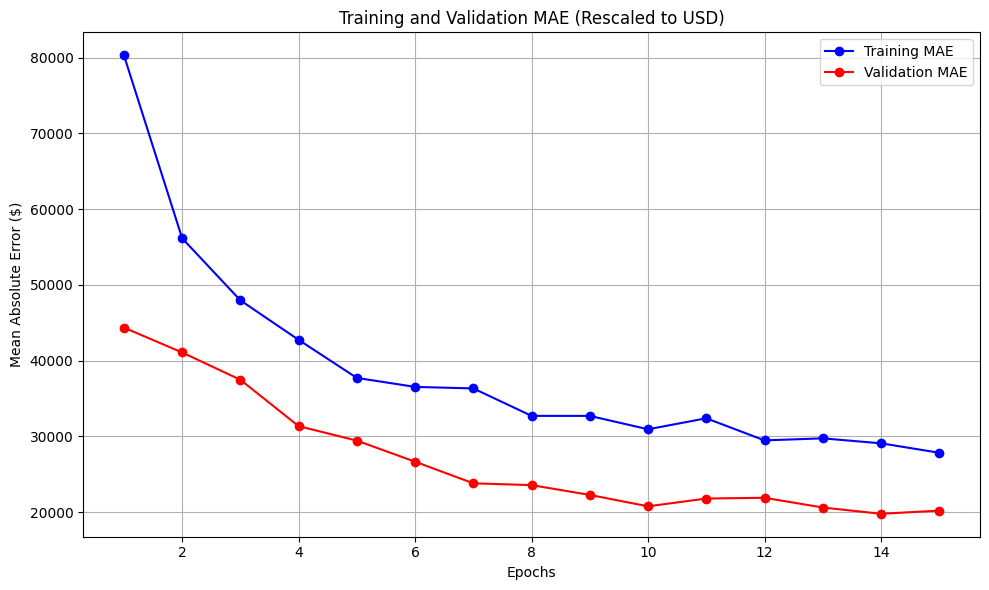

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

start = time.time()

early_stop = EarlyStopping(monitor="val_mae", patience=5, restore_best_weights=True)


model = Sequential(
    [
        Dense(32, activation="relu", input_shape=(x_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(16, activation="relu"),
        Dense(1),
    ]
)

# model = Sequential(
#     [
#         Dense(64, activation="relu", input_shape=(x_train.shape[1],)),
#         Dropout(0.4),
#         Dense(32, activation="relu"),
#         Dense(1),
#     ]
# )

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    x_train,
    y_train,
    epochs=15,
    validation_data=(x_val, y_val),
    batch_size=16,
    callbacks=[early_stop],
)

print(f"🕒 Celkový čas trénování: {time.time() - start:.2f} s")

val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
print(f"- ✅ finished: val_mae = {val_mae:.2f}")
print(f"- ✅ finished: val_mse = {val_mse:.2f}")

val_mae_usd = val_mae * scaler_sale_price.scale_[0]
val_rmse_usd = (val_mse * (scaler_sale_price.scale_[0] ** 2)) ** 0.5
print(f"- ✅ finished: val_mae = {val_mae:.2f} → ~${val_mae_usd:,.0f}")
print(f"- ✅ finished: val_rmse → ~${val_rmse_usd:,.0f}")


_ = utils.plot_rescaled_history(history.history, metric="mae", scaler=scaler_sale_price)

# Test build model


## Test on validation data


10/10 [==============================] - 0s 1ms/step


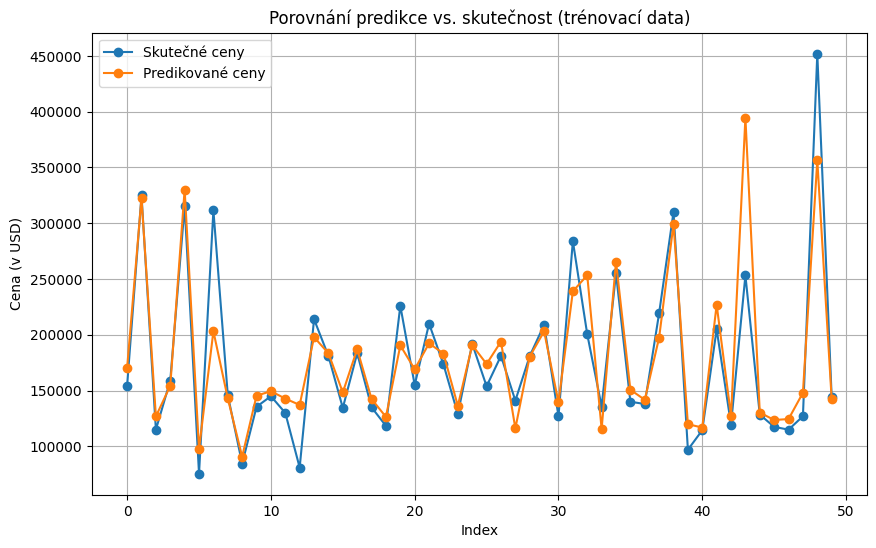

In [22]:
# 11. Předpověď na testovacích datech
y_pred_scaled = model.predict(x_val)

# 12. Inverze zpět na reálné ceny
y_pred_real = scaler_sale_price.inverse_transform(y_pred_scaled)
y_test_real = scaler_sale_price.inverse_transform(y_val.reshape(-1, 1))

# 13. Výstup porovnání
results = pd.DataFrame(
    {"Actual": y_test_real.flatten(), "Predicted": y_pred_real.flatten()}
)

count = 50
# print(results.head(count))

plt.figure(figsize=(10, 6))
plt.plot(results["Actual"][:count], marker="o", label="Skutečné ceny")
plt.plot(results["Predicted"][:count], marker="o", label="Predikované ceny")
plt.title("Porovnání predikce vs. skutečnost (trénovací data)")
plt.xlabel("Index")
plt.ylabel("Cena (v USD)")
plt.legend()
plt.grid(True)
plt.show()

## Test on test data


Load test data


In [25]:
path_test_data = "data_set/test.csv"
path_submission_data = "data_set/sample_submission.csv"

test_data_df = utils.load_csv_data(path_test_data)
y_target_df = utils.load_csv_data(path_submission_data)

# Print the loaded data
if isinstance(test_data_df, pd.DataFrame):
    print(f"dimension train data: {test_data_df.shape}")
    print(f"dimension train data: {type(test_data_df)}")
else:
    print("train_data is not a DataFrame")

# Print the loaded data
if isinstance(y_target_df, pd.DataFrame):
    print(f"dimension train data: {y_target_df.shape}")
    print(f"dimension train data: {type(y_target_df)}")
else:
    print("train_data is not a DataFrame")

del path_test_data, path_submission_data

Successfully loaded data from data_set/test.csv
Successfully loaded data from data_set/sample_submission.csv
dimension train data: (1459, 80)
dimension train data: <class 'pandas.core.frame.DataFrame'>
dimension train data: (1459, 2)
dimension train data: <class 'pandas.core.frame.DataFrame'>


In [26]:
print(type(test_data_df))
print(type(y_target_df))
print(test_data_df.shape)
print(y_target_df.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(1459, 80)
(1459, 2)


In [64]:
x_target_encoded.keys()

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'Exterior2nd_WdShing', 'MasVnrType_CBlock', 'ExterQual_Po',
       'BsmtQual_Po', 'BsmtCond_Ex', 'KitchenQual_Po', 'Functional_Sal',
       'PoolQC_TA', 'MiscFeature_Elev', 'SaleType_VWD'],
      dtype='object', length=902)

In [66]:
x_target_encoded = x_target_encoded.reindex(columns=train_columns, fill_value=0)
x_target_encoded.keys()

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'Exterior2nd_WdShing', 'MasVnrType_CBlock', 'ExterQual_Po',
       'BsmtQual_Po', 'BsmtCond_Ex', 'KitchenQual_Po', 'Functional_Sal',
       'PoolQC_TA', 'MiscFeature_Elev', 'SaleType_VWD'],
      dtype='object', length=902)

In [67]:
try:
    del x_target_encoded
except:
    print()


x_target = test_data_df.copy()

# 1. Drop nepotřebné sloupce
if "SalePrice" in x_target.columns:
    x_target = x_target.drop("SalePrice", axis=1)
if "Id" in x_target.columns:
    x_target = x_target.drop("Id", axis=1)

# 2. Missing values
x_target[categorical_cols] = x_target[categorical_cols].fillna("NA")
x_target[numerical_cols] = x_target[numerical_cols].fillna(-1)

# 3. One-hot encoding
x_target_encoded = pd.get_dummies(x_target, columns=categorical_cols)

# 4. Doplnění chybějících dummy sloupců
x_target_encoded = ensure_all_dummies(x_target_encoded, data_categories)

# 5. Znovu uspořádat a doplnit sloupce přesně podle train_columns
x_target_encoded = x_target_encoded.reindex(columns=train_columns, fill_value=0)

# # 6. Normalizace numerických hodnot
# existing_numerical_cols = [
#     col for col in numerical_cols if col in x_target_encoded.columns
# ]

# 💡 Warning: pokud nějaké chybí, doplníme je ručně před transformací
missing_cols = [col for col in numerical_cols if col not in x_target_encoded.columns]
# print(missing_cols)
# for col in missing_cols:
#     x_target_encoded[col] = -1  # stejná imputace jako ve train datech

# 1. Přidej chybějící numerické sloupce, pokud nejsou
for col in scaler_inputData.feature_names_in_:
    if col not in x_target_encoded.columns:
        x_target_encoded[col] = -1


# 2. Ujisti se, že je v přesném pořadí a má jen správné sloupce
x_numeric_target = x_target_encoded[numerical_cols].copy()
x_numeric_target = x_numeric_target[numerical_cols]  # explicitní pořadí!

print(
    x_numeric_target.columns.equals(scaler_inputData.feature_names_in_)
)  # musí být True

if x_numeric_target.columns.equals(scaler_inputData.feature_names_in_):
    # 3. Škáluj bez chyby
    x_target_encoded[numerical_cols] = scaler_inputData.transform(x_numeric_target)


# # 7. Převod na NumPy array
# x_target_final = x_target_encoded.to_numpy().astype("float32")

False


In [51]:
x_numeric_target.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [49]:
print(scaler_inputData.feature_names_in_)

['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold']


In [58]:
print(
    "Missing in target:",
    set(scaler_inputData.feature_names_in_) - set(x_numeric_target.columns),
)
print(
    "Extra in target:",
    set(x_numeric_target.columns) - set(scaler_inputData.feature_names_in_),
)

Missing in target: {'BsmtUnfSF', 'GarageArea', 'GarageCars', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtHalfBath'}
Extra in target: set()


In [ ]:
x = test_data_df.copy()

if "SalePrice" in x.columns:
    x = x.drop("SalePrice", axis=1)
if "Id" in x.columns:
    x = x.drop("Id", axis=1)

# Column types
numerical_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()

# Handle missing values
x[categorical_cols] = x[categorical_cols].fillna("NA")
x[numerical_cols] = x[numerical_cols].fillna(0)

# One-hot encode
x_encoded = pd.get_dummies(x, columns=categorical_cols)

# Align to training columns
x_encoded = x_encoded.reindex(columns=x_train_pd.columns, fill_value=0)

# Normalize using trained scaler
x_encoded[numerical_cols] = scaler_inputData.transform(x_encoded[numerical_cols])

# Convert to numpy
x_target = x_encoded.to_numpy().astype("float32")
y_target = y_target_df.to_numpy().astype("float32")

In [34]:
x = test_data_df
# Drop original SalePrice from df if present
print(x.shape)
if "SalePrice" in x.columns:
    x = x.drop("SalePrice", axis=1)
if "Id" in x.columns:
    x = x.drop("Id", axis=1)
print(x.shape)

# 1. Split columns by data type
numerical_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()

# 2. Handle missing values
x[categorical_cols] = x[categorical_cols].fillna(
    "NA"
)  # Fill missing categorical with "NA"
x[numerical_cols] = x[numerical_cols].fillna(0)  # Fill missing numerical with 0

# 3. One-hot encode categorical features
x_encoded = pd.get_dummies(x, columns=categorical_cols)

# 4. Normalize numerical features
# scaler_inputData = StandardScaler()
x_encoded[numerical_cols] = scaler_inputData.transform(x_encoded[numerical_cols])
# x_encoded[numerical_cols] = scaler_inputData.fit_transform(x_encoded[numerical_cols])
print(x_encoded.shape)
print(numerical_cols)
x_target = x_encoded.to_numpy().astype("float32")
y_target = y_target_df.to_numpy().astype("float32")

# 8. delete temporary data
del x_encoded, x

(1459, 80)
(1459, 79)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- BsmtFinSF1
- BsmtFinSF2
- BsmtFullBath
- BsmtHalfBath
- BsmtUnfSF
- ...


In [ ]:
print(type(x_target))
print(type(y_target))
print(x_target.shape)
print(y_target.shape)

In [ ]:
y_pred_scaled = model.predict(x_target)

y_pred_real = scaler_sale_price.inverse_transform(y_pred_scaled)
y_test_real = y_target.reshape(-1, 1)

results = pd.DataFrame(
    {"Actual": y_test_real.flatten(), "Predicted": y_pred_real.flatten()}
)

count = 50
print(results.head(count))

plt.figure(figsize=(10, 6))
plt.plot(results["Actual"][:count], marker="o", label="Skutečné ceny")
plt.plot(results["Predicted"][:count], marker="o", label="Predikované ceny")
plt.title("Porovnání predikce vs. skutečnost (trénovací data)")
plt.xlabel("Index")
plt.ylabel("Cena (v USD)")
plt.legend()
plt.grid(True)
plt.show()